# Assignment 2: Clustering California Housing with K-means

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://www.travelinusa.us/wp-content/uploads/sites/3/2017/11/Painted-Ladies-San-Francisco-01.jpg).

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.

**Note**: In order for your assignment to be graded, you must save your Notebook filename under this format: **yourUvaUserId_assignment_2_kmeans.ipynb**.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [ ]:
# You might want to use the following package
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Sid's imports: 
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import random


def load_housing_data(): 
  housing = pd.read_csv('/content/sample_data/california_housing_test.csv')
  return housing

# Your code goes here for this section.

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0


Lets do some imagery on the data overall including generating plots of each of the values. 

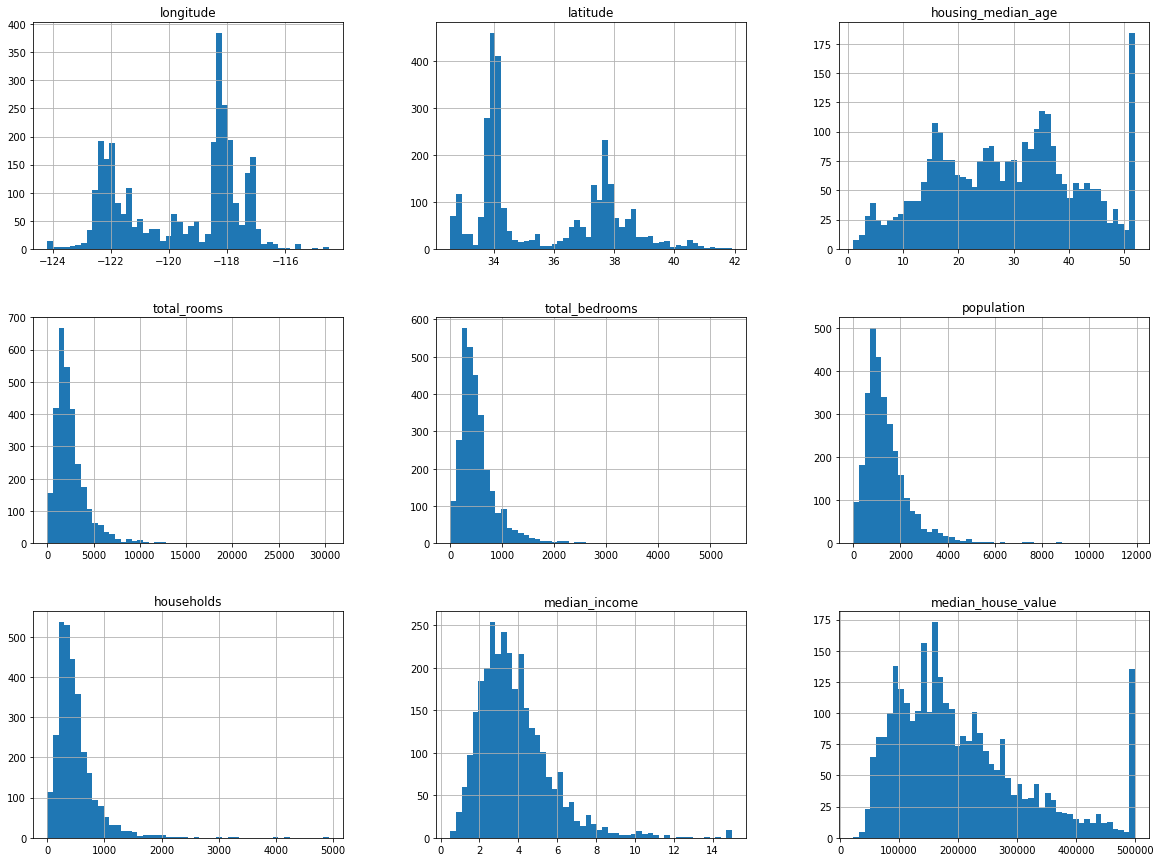

In [ ]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

A lot of this data is very similar to the end_to_end machine learning project that we looked at in the beginning of class. So we can borrow a lot of the methods used there and apply them here. 

Another thing is that this time I am going to use the train/test splits that were pre-established such that I look at none of the testing data. So instead of train/test splitting I will do all my work on this data and test later. 

Something they do next is that they transform the median_income to be more bell shaped due to its tail heavy distribution. But I actually don't want to do that. I first want to do k-means and then do data processing and try to see how much of an improvement boost the processing actually gives. 

Before we go further lets check if we have any missing values. 

In [ ]:
total_missing_data = housing.isnull().sum().sort_values(ascending=False)
percent = ( housing.isnull().sum() / housing.isnull().count() ).sort_values(ascending=False)
missing_data = pd.concat([total_missing_data, percent], axis = 1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
longitude,0,0.0
latitude,0,0.0
housing_median_age,0,0.0
total_rooms,0,0.0
total_bedrooms,0,0.0
population,0,0.0
households,0,0.0
median_income,0,0.0
median_house_value,0,0.0


Great, we have no missing values so lets not worry about it. The only optional thing we have to do is some data preprocessing/cleaning if we're up to it. 

But lets also do some visualization to get a map of where these houses are: 

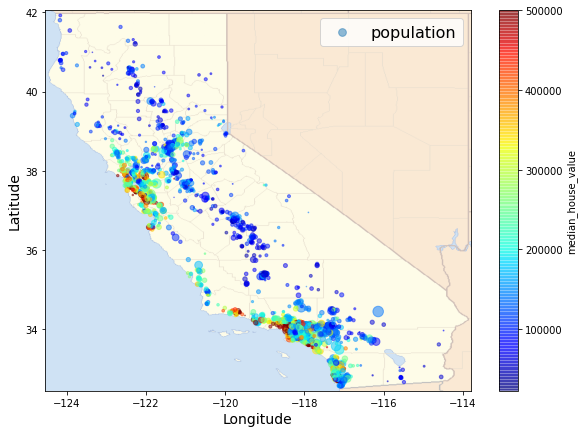

In [ ]:
import matplotlib.image as mpimg


california_img = mpimg.imread("/content/california.png")
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()

- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include three distance metrics: Manhattan Distance, Euclidean Distance, Sup Distance. These 3 distance metrics can be generalized by the Minkovski Distance:
$D(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}p]{\sum\limits_{i=1}^n|x_i - y_i|^p}$ where $p=1$ for Mahattan, $p=2$ for Euclidean, and $p=\infty$ for Sup Distance.

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [ ]:
# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).

# lets do this how we did assignment 1 and have a class-based system, that seemed to work well. 

class myKMeans: 
  def __init__(self): 
    self.centroidLocations = [[0, 0]]
    self.centroidBuckets = [] # a list of np arrays?
    self.centroids = 1
    self.p = 1
    # we default to a Manhattan distance

  #inputs: two nparrays x and y
  #output: minkovski distance between the two
  def minkovskiDistance(self, x, y): 
    # ok for performance reasons, I want this function to be REALLY fast
    # so I'll write code here that would implement it but just use a scipy 
    # function in the end.
    # assuming x and y are a numpy array:
    if ( self.p == 0 ): 
      # print("bob")
      # print("x: " + str(x))
      # print("y: " + str(y[0]))
      # print(y[0])
      # print(type(y[0]))
      return max(np.absolute(x - np.array(y[0])[0]))
    else: 
      return np.power( np.sum( np.absolute(np.power( x - y[0] , self.p) )) , 1/self.p)

    # the reason I can return the max of the array is that according to this
    # wikipedia article, as p approaches infinity, the Minkovski distance 
    # becomes equal to the max of the difference between two values. 


  def initializeCentroids(self, dataset, K): 
    # in this function we initialize K centroids each of length of the number of rows 
    # and save them to our self.centroidLocation

    # actually, a better way to go about this is to pick K random points within the 
    # dataset and use those as centroids
    self.centroidLocations = []
    self.centroidBuckets = []
    self.centroids = K
    for i in range(K): 
      # we have to do this goofy math so that we don't select from the same value twice
      self.centroidLocations.append( dataset[( i * int(len(dataset)/K) ) + random.randint(0, int(len(dataset)/K)) ])
      self.centroidBuckets.append([])

    self.centroidLocations = np.asmatrix(self.centroidLocations)

  def closestCentroid(self, x): 
    minDistance = 1000000
    minCentroid = 0
    for i in range(self.centroids): 
      # print("i: " + str(i))
      # print( "self.minkovskiDistance(x, self.centroidLocations[i]): " + str(self.minkovskiDistance(x, self.centroidLocations[i])) )
      # print( "minDistance: " + str(minDistance))

      if ( self.minkovskiDistance(x, self.centroidLocations[i]) < minDistance ):
        minDistance = self.minkovskiDistance(x, self.centroidLocations[i])
        minCentroid = i

    # print("minCentroid: " + str(minCentroid))
    return minCentroid


  # this functoin calls closestCentroid to find the centroid with the
  # closest distance and assign said value to the centroid's bucket
  def assignToCluster(self, dataset): 
    for i in range(len(self.centroidBuckets)): 
      self.centroidBuckets[i] = [] 
    for i in dataset:
      self.centroidBuckets[self.closestCentroid(i)].append(i)

  def computeCentroids(self):
    for i in range(self.centroids):
      self.centroidLocations[i] = np.sum(self.centroidBuckets[i], axis=0) / max(len(self.centroidBuckets[i]), 1)

  def comparePriorCentroids(self, previousCentroids): 
    difference = 0
    for i in range(len(previousCentroids)): 
      difference += np.power( np.sum( np.power( previousCentroids[i] - self.centroidLocations[i] , 2) ) , 1/2)
    return difference

  # we recompute cluster centers until we have no change in housing assignment. 
  # that's a little expensive to do. So something easier would be check the distance
  # between cluster centers and ensure that it is below a certain bounds
  # assuming the dataset is an nparray
  def driver(self, dataset, p = 1, K=2): 
    self.p = p
    self.centroids = K

    self.initializeCentroids(dataset, self.centroids)
    # print("init centroidLocations: " + str(self.centroidLocations))
    prevSSE = self.SSE()
    
    self.assignToCluster(dataset)
    # print("init clusters: " + str(self.centroidBuckets))
    self.computeCentroids()
    # print("second Ceontrids " + str(self.centroidLocations))
    
    # change value here to improve SSE and similarity to python
    # built in KMeans *****************************************
    while ( abs(prevSSE - self.SSE()) > 0.0000000000000001 ):
      # print( "SSE: " + str(prevSSE) )
      # print( self.centroidLocations ) 
      self.assignToCluster(dataset)
      self.computeCentroids()
      prevSSE = self.SSE()

  def SSE(self): 
    SSEVal = 0
    for i in range(self.centroids): 
      for j in range(len(self.centroidBuckets[i])):
        SSEVal += np.sum( np.power( self.centroidLocations[i] - self.centroidBuckets[i][j] , 2) )

    return SSEVal



In [ ]:
myFunction = myKMeans()
dataset = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10.5], [9, 30], [123, 456]]
dataset = np.array(dataset)

myFunction.driver(dataset=dataset, p=1)
print("Done")
print(myFunction.centroidLocations)

Done
[[  5.66666667  10.08333333]
 [123.         456.        ]]


In [ ]:
print(myFunction.centroidBuckets)

[[array([1., 2.]), array([3., 4.]), array([5., 6.]), array([7., 8.]), array([ 9. , 10.5]), array([ 9., 30.])], [array([123., 456.])]]


In [ ]:
print(myFunction.SSE())

573.5416666666666


- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Report the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Increase the value of k from 2 to 3,4,..,10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.


In [ ]:
HousingDataClustering = myKMeans()
data = housing.to_numpy()
HousingDataClustering.driver(dataset=data, p=2, K=2)
print("Done")
print(HousingDataClustering.centroidLocations)
myCentroids = HousingDataClustering.centroidLocations

Done
[[-1.19861541e+02  3.54610306e+01  3.00371402e+01  2.99486630e+03
   5.64636955e+02  1.37771866e+03  5.28553389e+02  5.15607029e+00
   3.29246541e+05]
 [-1.19436672e+02  3.57330421e+01  2.81778471e+01  2.37819293e+03
   5.10524181e+02  1.41684503e+03  4.68270411e+02  3.05186048e+00
   1.36734425e+05]]


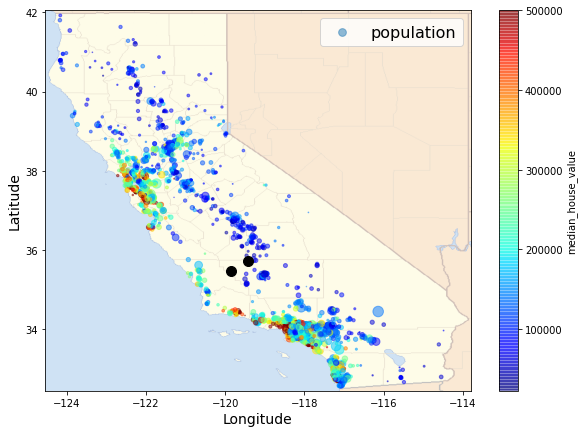

In [ ]:
california_img = mpimg.imread("/content/california.png")
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

for i in myCentroids: 
  plt.plot( i[0, 0], i[0, 1], color='black', marker='o', markersize=10)

#plt.plot( [centroids[0, 0], centroids[1, 0]], [centroids[0, 1], centroids[1, 1]], color='', marker='o')


plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()


In [ ]:
print(HousingDataClustering.SSE())

12807904147572.201


Comparing with the built-in implementation of KMeans: 

[[-1.19479923e+02  3.56966425e+01  2.82656109e+01  2.43623846e+03
   5.17147964e+02  1.42109095e+03  4.75203620e+02  3.21141846e+00
   1.49957557e+05]
 [-1.19894899e+02  3.54640380e+01  3.04670886e+01  3.05651772e+03
   5.65765823e+02  1.35162658e+03  5.31058228e+02  5.47415266e+00
   3.62193196e+05]]


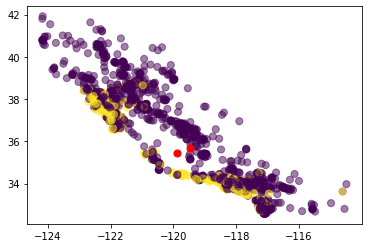

12179117132703.984


In [ ]:
from sklearn.cluster import KMeans
  
kmeans = KMeans(n_clusters=2).fit(housing)
centroids = kmeans.cluster_centers_
print(centroids)

plt.scatter(housing['longitude'], housing['latitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

print(kmeans.inertia_)

Ok so my implementation works. Initially I was super confused and thought that I did something really wrong but it appears to be fine. As we can see, with the current set of clusters, location isn't 'strong" enough to split up the data points. Lets add more clusters and check. 

Lookin at the SSE, I get pretty close but not close enough to the python built-in. This is probably due to my loose bounds to determine when to stop iterating on cluster centers. 

In [ ]:
cluster01 = pd.DataFrame(HousingDataClustering.centroidBuckets[0])
cluster01.columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
cluster01.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000,1077.000000
mean,-119.861541,35.461031,30.037140,2994.866295,564.636955,1377.718663,528.553389,5.156070,329246.541318
std,2.029020,1.880146,12.931206,2384.862378,460.178456,1015.870889,407.766430,2.140169,89605.692755
min,-122.870000,32.680000,2.000000,18.000000,3.000000,5.000000,3.000000,0.499900,223700.000000
25%,-122.040000,33.920000,20.000000,1704.000000,303.000000,774.000000,290.000000,3.732100,253800.000000
50%,-118.550000,34.210000,30.000000,2476.000000,465.000000,1130.000000,437.000000,4.800000,301200.000000
75%,-118.120000,37.530000,39.000000,3559.000000,672.000000,1699.000000,639.000000,6.135900,387000.000000
max,-114.620000,39.240000,52.000000,24121.000000,5419.000000,10877.000000,4930.000000,15.000100,500001.000000


In [ ]:
cluster02 = pd.DataFrame(HousingDataClustering.centroidBuckets[1])
cluster02.columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
cluster02.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000,1923.000000
mean,-119.436672,35.733042,28.177847,2378.192928,510.524181,1416.845034,468.270411,3.051860,136734.425377
std,1.959648,2.251980,12.292930,1982.328845,387.266833,1038.667764,337.593175,1.100819,46471.407079
min,-124.180000,32.560000,1.000000,6.000000,2.000000,8.000000,2.000000,0.536000,22500.000000
25%,-121.350000,33.940000,18.000000,1289.500000,282.000000,786.000000,266.000000,2.227850,97950.000000
50%,-118.440000,34.410000,29.000000,1912.000000,420.000000,1182.000000,390.000000,2.973700,139300.000000
75%,-117.950000,37.795000,37.000000,2877.500000,618.500000,1758.000000,578.000000,3.814050,173850.000000
max,-114.490000,41.920000,52.000000,30450.000000,5033.000000,11935.000000,4855.000000,6.864500,223200.000000


Looking at these two clusters, we can see that they are split on values of median house value. Lets check this with some histograms: 

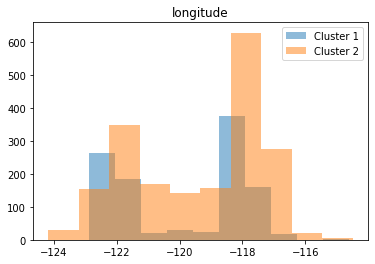

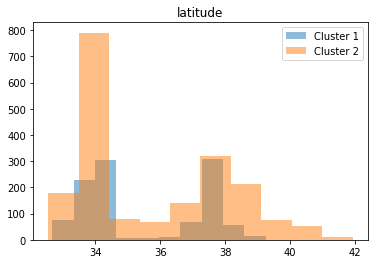

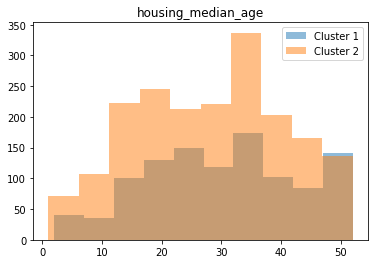

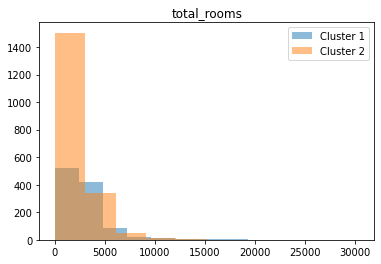

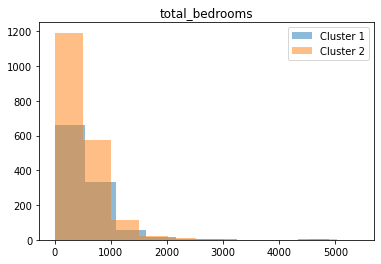

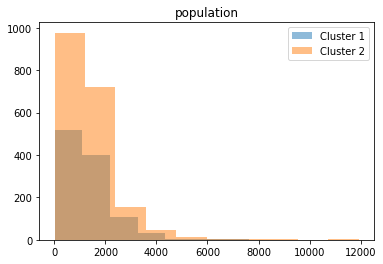

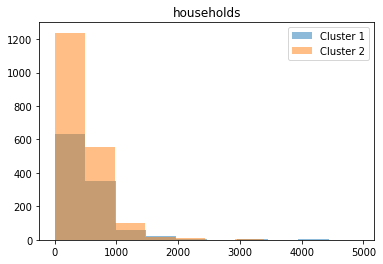

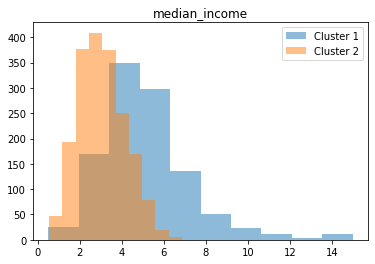

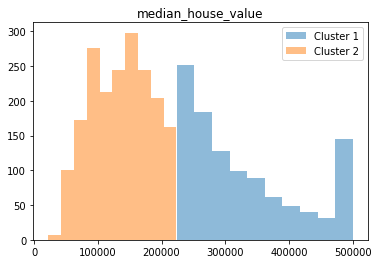

In [ ]:
columnLabels = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

for i in columnLabels: 
  x = cluster01[i]
  y = cluster02[i]

  plt.hist(x, alpha=0.5, label='Cluster 1')
  plt.hist(y, alpha=0.5, label='Cluster 2')  
  plt.legend(loc='upper right')
  plt.title(i)
  plt.show()


As suspected. Now lets do as we were required to do and add more clusters. Ok I'm not going to include visualizations and all for each clustering in this notebook but I will enable a way to go between them. I feel that having visuals for all 10 cluster options will just clutter up the notebook and annoy me too much. 

Done
[[-1.19182897e+02  3.50571032e+01  2.81785714e+01  2.60873413e+03
   5.59309524e+02  1.51979960e+03  5.21436508e+02  3.63628393e+00
   1.87057143e+05]
 [-1.19857692e+02  3.69032418e+01  3.02857143e+01  1.65801648e+03
   3.80615385e+02  1.03845055e+03  3.44521978e+02  1.94718956e+00
   5.92846154e+04]
 [-1.19858480e+02  3.54733600e+01  2.90880000e+01  2.83656000e+03
   5.34112000e+02  1.33204800e+03  5.04512000e+02  4.86671120e+00
   3.13691200e+05]
 [-1.19789980e+02  3.64504628e+01  2.79134809e+01  2.22474044e+03
   4.79486922e+02  1.29741650e+03  4.34010060e+02  2.60155453e+00
   9.38042254e+04]
 [-1.19881702e+02  3.54515957e+01  2.90638298e+01  3.11485106e+03
   5.98053191e+02  1.40302128e+03  5.65968085e+02  4.75999574e+00
   2.86668085e+05]
 [-1.20085845e+02  3.56281643e+01  3.06908213e+01  3.16902415e+03
   5.88057971e+02  1.41122705e+03  5.51772947e+02  5.35820821e+00
   3.65269082e+05]
 [-1.19700603e+02  3.54011782e+01  2.87241379e+01  2.78615230e+03
   5.62183908e+02  1.47

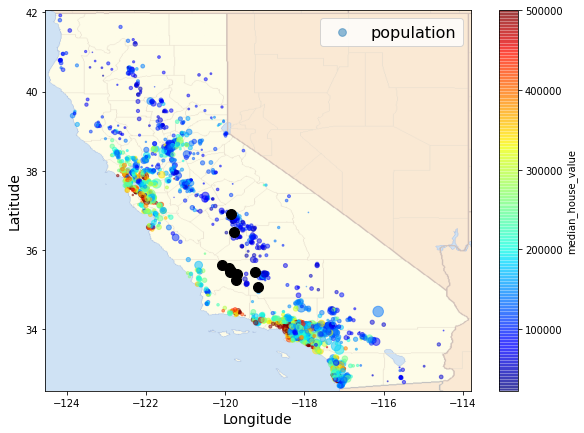

SSE is equal to: 702543257371.4565


In [ ]:
numberOfClusters = 10
# change cluster number here ^^^^^^^

HousingDataClustering001 = myKMeans()
data = housing.to_numpy()
HousingDataClustering001.driver(dataset=data, p=2, K=numberOfClusters)
print("Done")
print(HousingDataClustering001.centroidLocations)
myCentroids = HousingDataClustering001.centroidLocations

california_img = mpimg.imread("/content/california.png")
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

for i in myCentroids: 
  plt.plot( i[0, 0], i[0, 1], color='black', marker='o', markersize=10)

#plt.plot( [centroids[0, 0], centroids[1, 0]], [centroids[0, 1], centroids[1, 1]], color='', marker='o')


plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()

print("SSE is equal to: " + str(HousingDataClustering001.SSE()))

Looking at median and stdev values for each cluster: 

In [ ]:
for idx, cluster in enumerate(HousingDataClustering001.centroidBuckets): 
  print("Statistics for cluster " + str(idx) + ": ")
  clusterDF = pd.DataFrame(cluster)
  clusterDF.columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
  print(clusterDF.describe())

Statistics for cluster 0: 
        longitude    latitude  housing_median_age   total_rooms  \
count  504.000000  504.000000          504.000000    504.000000   
mean  -119.182897   35.057103           28.178571   2608.734127   
std      1.852243    1.904430           11.711401   2515.037105   
min   -122.840000   32.610000            2.000000     21.000000   
25%   -121.240000   33.860000           19.000000   1443.500000   
50%   -118.270000   34.090000           30.000000   2071.500000   
75%   -117.950000   37.350000           36.000000   3038.000000   
max   -116.830000   39.690000           52.000000  30450.000000   

       total_bedrooms    population   households  median_income  \
count      504.000000    504.000000   504.000000     504.000000   
mean       559.309524   1519.799603   521.436508       3.636284   
std        471.908552   1142.109896   408.443279       1.072260   
min          7.000000     21.000000     9.000000       0.818500   
25%        301.750000    881.75000

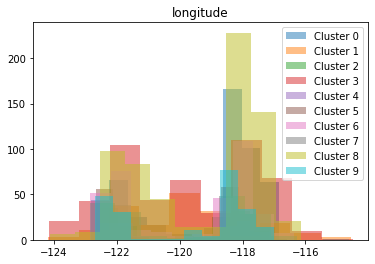

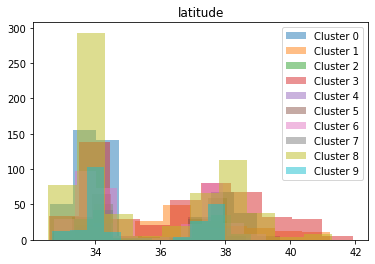

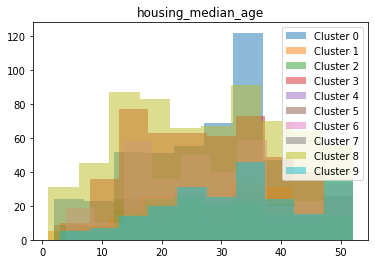

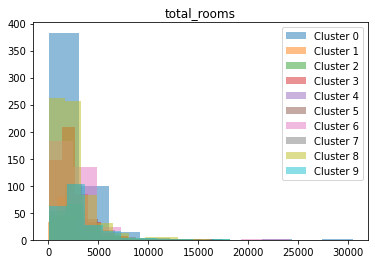

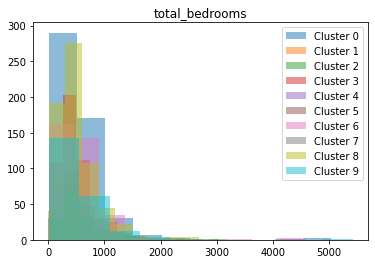

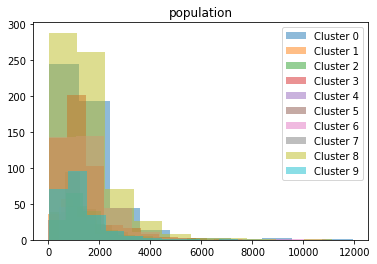

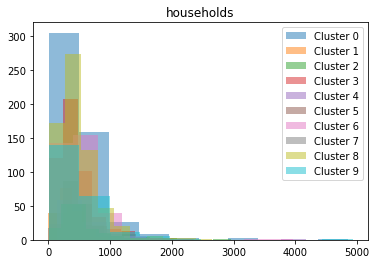

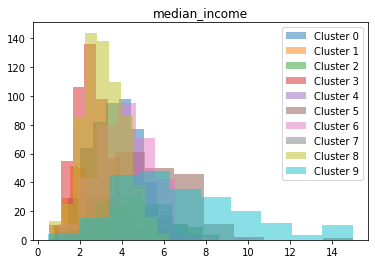

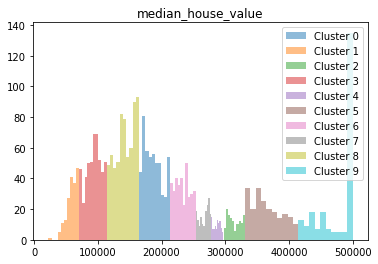

In [ ]:
columnLabels = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
clusterDataFrames = []

for i in range(numberOfClusters): 
  clusterDataFrames.append(pd.DataFrame(HousingDataClustering001.centroidBuckets[i]))
  clusterDataFrames[i].columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

for i in columnLabels: 
  for j in range(len(clusterDataFrames)): 
    plt.hist(clusterDataFrames[j][i], alpha=0.5, label='Cluster ' + str(j))
  plt.legend(loc='upper right')
  plt.title(i)
  plt.show()

Comparing to the built-in: 

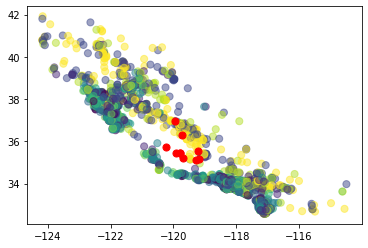

451153396838.7


In [ ]:
from sklearn.cluster import KMeans
  
kmeans = KMeans(n_clusters=numberOfClusters).fit(housing)
centroids = kmeans.cluster_centers_
# print(centroids)

plt.scatter(housing['longitude'], housing['latitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

print(kmeans.inertia_)

Ok still not bad, they are fairly similar and aren't so far off that I think it would be a problem. Again, I would fix this issue (by turning down the parameter in the driver function). But I think that we're so close that its ok.

Additionally, I could display statistics (mean, std. dev.) for each cluster but I find these histograms far easier to look at. 

This is becuase we can see how exactly the KMeans splits up the houses. It seems that KMeans is inclined to split up housing based off median house value. This kind of makes sense as median_house_value has the largest value and by splitting on median_house_value, we can most easily reduce inter-cluster distances. Maybe I should standard scale the data a bit???? To reduce the outsized effect of median_house_value? 

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
columnLabels = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]



full_pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy="median")),
     ('scaler', StandardScaler())]
)

housing_prepared = pd.DataFrame(full_pipeline.fit_transform(housing))

Done
[[ 0.77167018 -0.73616543 -0.39411708  0.39411692  0.63998585  0.79379125
   0.63899208 -0.45662851 -0.43629497]
 [-1.16378174  1.14430944 -0.09997389  0.34540516  0.42318331  0.38505137
   0.45505163 -0.21313047 -0.20686095]
 [ 0.68831684 -0.79727039  0.74186021 -0.31395039 -0.32475131 -0.31772145
  -0.30310431  0.15450132  0.48369123]
 [-0.74677787  1.13111716 -0.40512987 -0.48350622 -0.49610593 -0.56024487
  -0.54514846 -0.59294404 -0.89938148]
 [ 0.20195524 -0.38056027 -0.56452973  1.1809404   0.8668375   0.80591437
   0.9583999   1.24833072  1.41688135]
 [ 0.9421225  -0.91062576 -0.9315144  -0.2543238  -0.35902991 -0.38022357
  -0.37205681  0.46540535  0.12230089]
 [-1.25878123  0.98046659  0.70760369 -0.46610977 -0.53994906 -0.61714875
  -0.54054661  0.22913219  0.49460162]
 [ 0.80696699 -0.75740866  0.63988861 -0.68882732 -0.62510098 -0.50451389
  -0.64822354 -0.75791905 -0.71637579]
 [ 0.39984549 -0.26127769 -1.24707078  3.89868936  3.83381304  3.51962731
   3.75636762  0.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


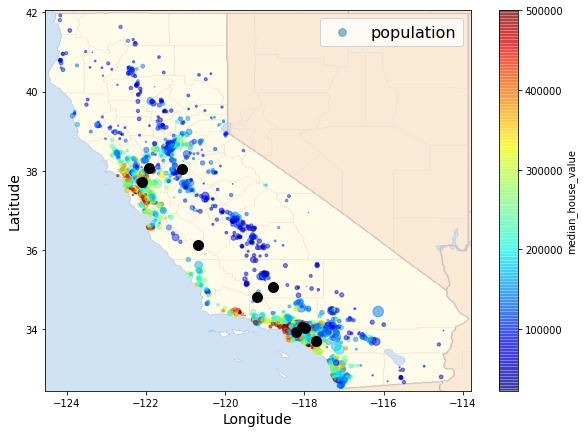

SSE is equal to: 9843.966619362978


In [ ]:
numberOfClusters = 10

HousingDataClustering = myKMeans()
data = housing_prepared.to_numpy()
HousingDataClustering.driver(dataset=data, p=2, K=numberOfClusters)
print("Done")
print(HousingDataClustering.centroidLocations)
myCentroids = HousingDataClustering.centroidLocations
myCentroids = full_pipeline['scaler'].inverse_transform(HousingDataClustering.centroidLocations)

california_img = mpimg.imread("/content/california.png")
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

for i in myCentroids: 
  plt.plot( i[0], i[1], color='black', marker='o', markersize=10)

#plt.plot( [centroids[0, 0], centroids[1, 0]], [centroids[0, 1], centroids[1, 1]], color='', marker='o')


plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()

print("SSE is equal to: " + str(HousingDataClustering.SSE()))

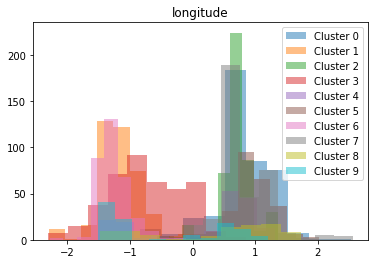

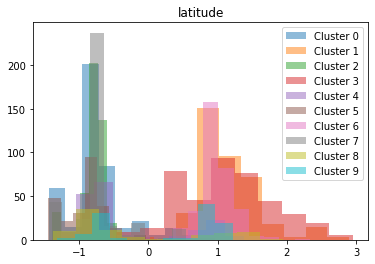

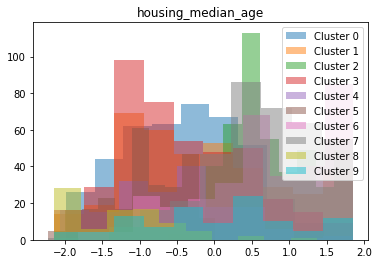

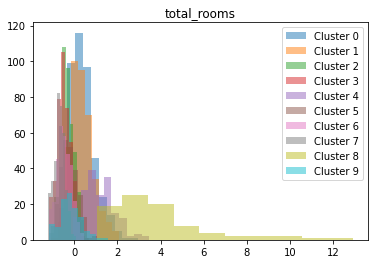

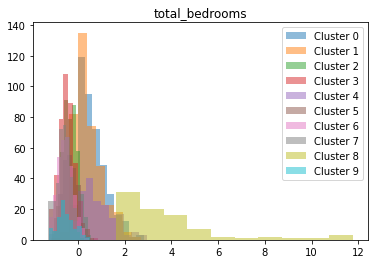

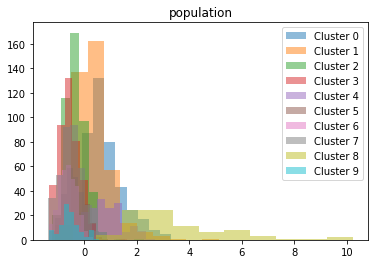

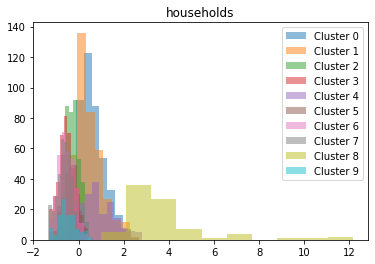

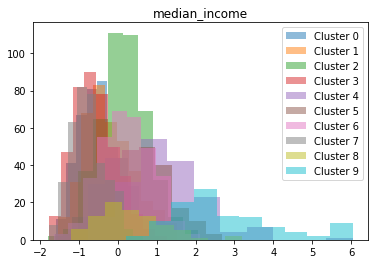

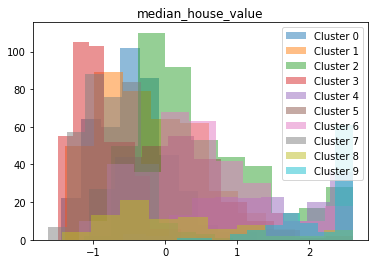

In [ ]:
columnLabels = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
clusterDataFrames = []

for i in range(numberOfClusters): 
  clusterDataFrames.append(pd.DataFrame(HousingDataClustering.centroidBuckets[i]))
  clusterDataFrames[i].columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

for i in columnLabels: 
  for j in range(len(clusterDataFrames)): 
    plt.hist(clusterDataFrames[j][i], alpha=0.5, label='Cluster ' + str(j))
  plt.legend(loc='upper right')
  plt.title(i)
  plt.show()

Here we can see a far more diverse clustering particularly in cluster 8 but I can't seem to make sense of these clusters. 

Ah actually. Looking at a map of California. We can see how these clusters match up to San Fran, Silicon Valley, Sacramento, Fresno, Bakersfield, Beverly Hills, Pasadena, Long Beach, and Irvine.

Interesting. I thought the clusters would be more distributed in terms of median house value even after being scaled but they seem to care a lot about location once scaled. 

I'm going to try exploring number of clusters on a scaled version of the data via the built-in KMeans function because I find my code clunky and would rather not use it if it can be helped. 

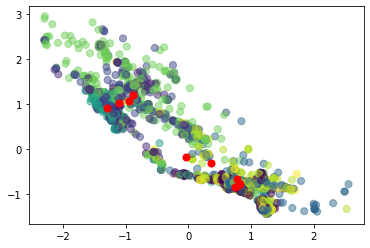

8579.958218139


In [ ]:
kmeans = KMeans(n_clusters=numberOfClusters).fit(housing_prepared)
centroids = kmeans.cluster_centers_
# print(centroids)

housing_prepared_df = pd.DataFrame(housing_prepared)
housing_prepared_df.columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

plt.scatter(housing_prepared['longitude'], housing_prepared['latitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

print(kmeans.inertia_)

I find that once scaled, granularity peaks at around 7-8 clusters and the cluster centers converge onto major population centers but past that the clusters kind of go haywire. 

Lets also look into changing the which method of Minkovski distance we're going to be using. For visualizations, I'm going to leave us with 10 clusters and only vary Minkovski distance even though I've tested all levels of nodes with all variations of Minkovski distance. 

Minkovski where k = 1: 

Done
[[ 6.89111474e-01 -7.08718988e-01 -7.64540407e-01  1.26115441e-01
  -2.39856008e-02 -9.22290347e-03 -5.99477248e-03  5.83072589e-01
   2.76834957e-01]
 [ 6.58069991e-01 -7.97544606e-01  7.04037824e-01 -7.21632380e-02
  -2.51681580e-01 -3.86811823e-01 -2.38213798e-01  1.40396192e+00
   1.88287392e+00]
 [-8.35833309e-01  1.16714428e+00  4.66682565e-02 -4.49155934e-01
  -4.31675825e-01 -4.66948835e-01 -4.64807571e-01 -7.25360491e-01
  -9.44250036e-01]
 [ 8.36755966e-01 -8.41537703e-01 -3.88130236e-03 -6.45974451e-01
  -7.20515298e-01 -7.17781794e-01 -7.40088687e-01  2.44053775e-01
   7.67023344e-02]
 [-1.33710289e+00  9.39503018e-01  1.30171431e+00 -2.71754965e-01
  -2.85193331e-01 -3.94757445e-01 -2.73744808e-01  2.33105684e-01
   8.53608663e-01]
 [ 8.10143701e-01 -8.15881846e-01  5.17096422e-01 -4.48060422e-01
  -3.24559383e-01 -1.81151448e-01 -3.21130086e-01 -6.35130264e-01
  -5.28628013e-01]
 [-1.17525225e+00  1.03764087e+00 -5.48795252e-01 -1.54876471e-01
  -3.10596616e-01 -3.09

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


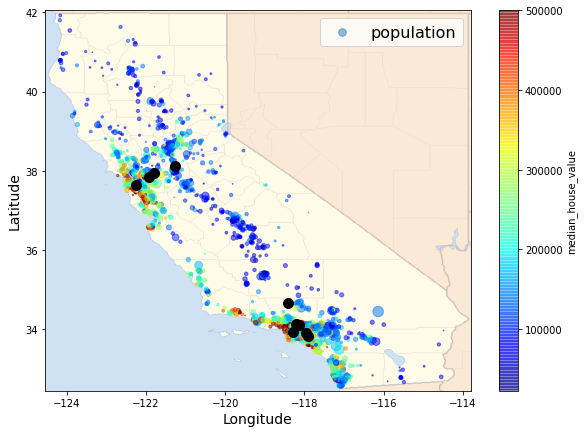

SSE is equal to: 9896.391543914779


In [ ]:
numberOfClusters = 10

HousingDataClustering01 = myKMeans()
data = housing_prepared.to_numpy()
HousingDataClustering01.driver(dataset=data, p=1, K=numberOfClusters)
print("Done")
print(HousingDataClustering01.centroidLocations)
myCentroids = HousingDataClustering01.centroidLocations
myCentroids = full_pipeline['scaler'].inverse_transform(HousingDataClustering01.centroidLocations)

california_img = mpimg.imread("/content/california.png")
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

for i in myCentroids: 
  plt.plot( i[0], i[1], color='black', marker='o', markersize=10)

#plt.plot( [centroids[0, 0], centroids[1, 0]], [centroids[0, 1], centroids[1, 1]], color='', marker='o')


plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()

print("SSE is equal to: " + str(HousingDataClustering01.SSE()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """


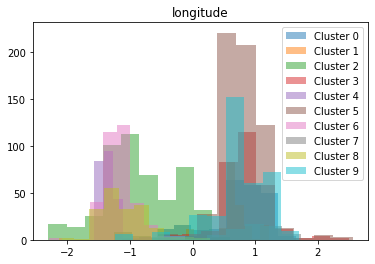

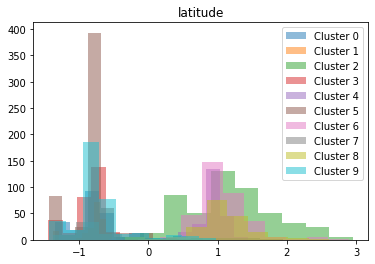

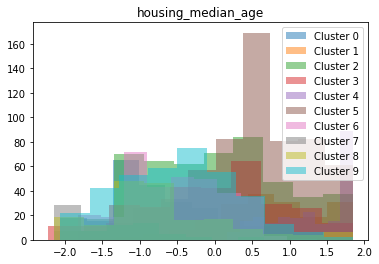

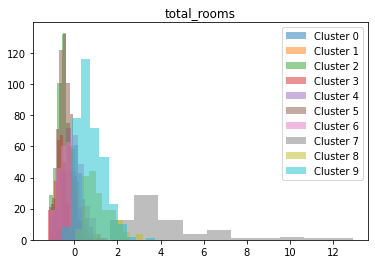

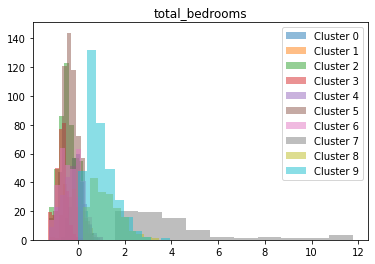

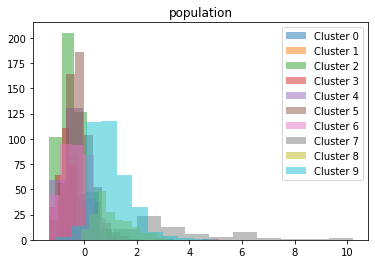

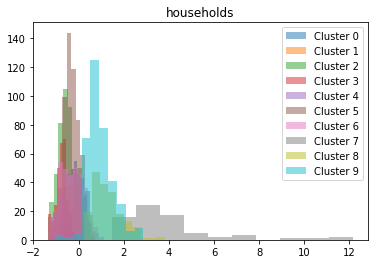

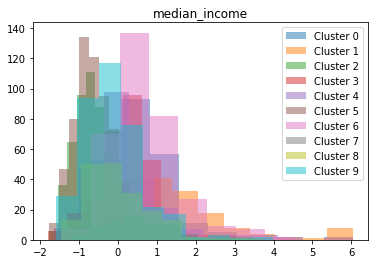

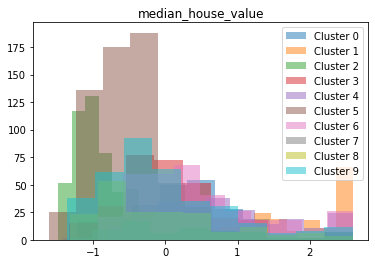

In [ ]:
columnLabels = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
clusterDataFrames = []

for i in range(numberOfClusters): 
  clusterDataFrames.append(pd.DataFrame(pd.np.empty((0, 9))))
  clusterDataFrames[i] = pd.DataFrame(HousingDataClustering01.centroidBuckets[i])
  # print(clusterDataFrames[i])
  clusterDataFrames[i].columns = columnLabels

for i in columnLabels: 
  for j in range(len(clusterDataFrames)): 
    plt.hist(clusterDataFrames[j][i], alpha=0.5, label='Cluster ' + str(j))
  plt.legend(loc='upper right')
  plt.title(i)
  plt.show()

In [ ]:
for idx, cluster in enumerate(HousingDataClustering01.centroidBuckets): 
  print("Statistics for cluster " + str(idx) + ": ")
  clusterDF = pd.DataFrame(cluster)
  clusterDF.columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
  print(clusterDF.describe())

Statistics for cluster 0: 
        longitude    latitude  housing_median_age  total_rooms  \
count  230.000000  230.000000          230.000000   230.000000   
mean     0.689111   -0.708719           -0.764540     0.126115   
std      0.507371    0.427005            0.659398     0.305137   
min     -1.128445   -1.350383           -2.058847    -0.533389   
25%      0.561114   -0.904230           -1.102924    -0.088890   
50%      0.811790   -0.805607           -0.863943     0.090905   
75%      0.970970   -0.637712           -0.385981     0.302135   
max      1.644036    0.786455            1.446206     1.211201   

       total_bedrooms  population  households  median_income  \
count      230.000000  230.000000  230.000000     230.000000   
mean        -0.023986   -0.009223   -0.005995       0.583073   
std          0.258665    0.314805    0.260102       0.891685   
min         -0.743411   -0.872306   -0.818126      -1.417467   
25%         -0.185162   -0.212349   -0.158506       0.0579

Minkovski where k = 2

Done
[[-1.26883387  0.95830213  0.55716413 -0.28156722 -0.37019254 -0.41868275
  -0.35784027  0.48986324  0.71963481]
 [ 0.60346659 -0.72374825 -0.54205939  0.74243939  0.37242934  0.36116825
   0.44365288  1.48721093  1.36146113]
 [ 0.64407259 -0.78331848  0.66148631 -0.28962703 -0.42849887 -0.547904
  -0.43170818  1.27073254  1.77821467]
 [ 0.59281238 -0.59418016  1.11728639 -0.71814727 -0.68711294 -0.64357194
  -0.70307436 -0.62392033 -0.46521563]
 [-1.1558809   1.0044838  -0.71465794  1.34785044  1.43524557  1.31493443
   1.53389484  0.07613257  0.09103605]
 [ 0.6625605  -0.53716115 -1.28584723  3.92391935  3.83929924  3.52419194
   3.72859321  0.38364622  0.26761412]
 [ 0.60801534 -0.60253967  0.4523107  -0.28119223 -0.19537781 -0.02482561
  -0.16894874 -0.40898791 -0.44631437]
 [ 0.97141058 -0.88079131 -0.80571995 -0.4329567  -0.43686883 -0.47944527
  -0.47518751 -0.05634919 -0.27964092]
 [ 0.73683454 -0.70733065 -0.45161637  0.6471139   0.91082355  1.04645784
   0.91434538 -0.34

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


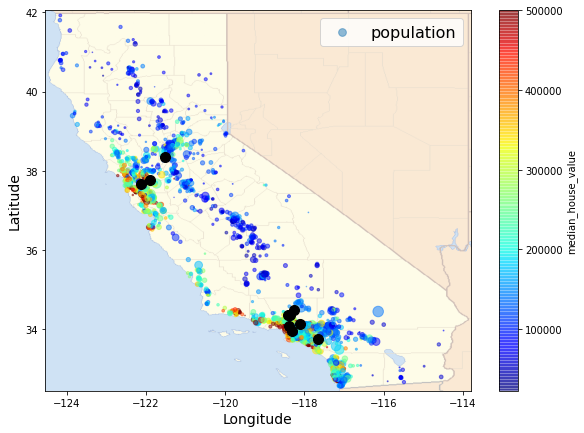

SSE is equal to: 9991.367120449586


In [ ]:
numberOfClusters = 10

HousingDataClustering02 = myKMeans()
data = housing_prepared.to_numpy()
HousingDataClustering02.driver(dataset=data, p=2, K=numberOfClusters)
print("Done")
print(HousingDataClustering02.centroidLocations)
myCentroids = HousingDataClustering02.centroidLocations
myCentroids = full_pipeline['scaler'].inverse_transform(HousingDataClustering02.centroidLocations)

california_img = mpimg.imread("/content/california.png")
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

for i in myCentroids: 
  plt.plot( i[0], i[1], color='black', marker='o', markersize=10)

#plt.plot( [centroids[0, 0], centroids[1, 0]], [centroids[0, 1], centroids[1, 1]], color='', marker='o')


plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()

print("SSE is equal to: " + str(HousingDataClustering02.SSE()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """


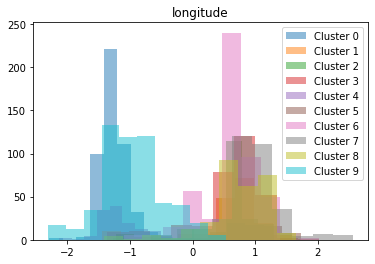

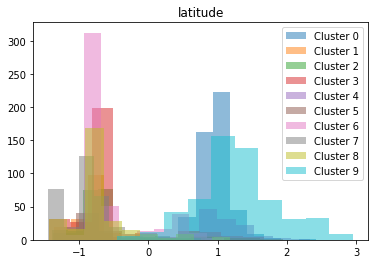

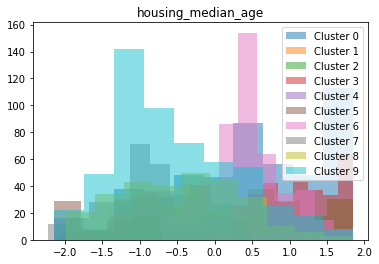

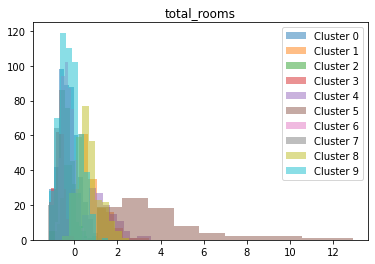

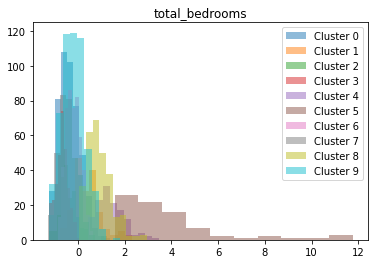

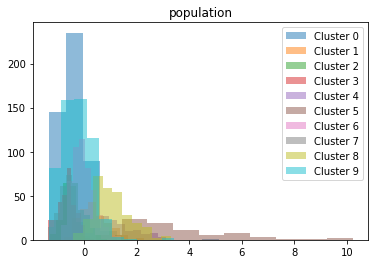

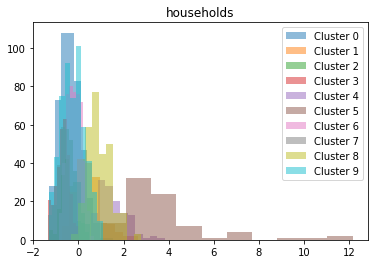

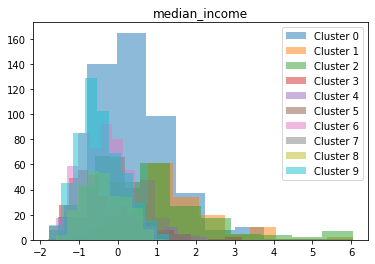

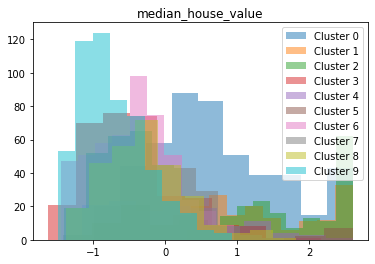

In [ ]:
columnLabels = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
clusterDataFrames = []

for i in range(numberOfClusters): 
  clusterDataFrames.append(pd.DataFrame(pd.np.empty((0, 9))))
  clusterDataFrames[i] = pd.DataFrame(HousingDataClustering02.centroidBuckets[i])
  # print(clusterDataFrames[i])
  clusterDataFrames[i].columns = columnLabels

for i in columnLabels: 
  for j in range(len(clusterDataFrames)): 
    plt.hist(clusterDataFrames[j][i], alpha=0.5, label='Cluster ' + str(j))
  plt.legend(loc='upper right')
  plt.title(i)
  plt.show()

In [ ]:
for idx, cluster in enumerate(HousingDataClustering02.centroidBuckets): 
  print("Statistics for cluster " + str(idx) + ": ")
  clusterDF = pd.DataFrame(cluster)
  clusterDF.columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
  print(clusterDF.describe())

Statistics for cluster 0: 
        longitude    latitude  housing_median_age  total_rooms  \
count  480.000000  480.000000          480.000000   480.000000   
mean    -1.268834    0.958302            0.557164    -0.281567   
std      0.203367    0.227563            0.975436     0.455743   
min     -2.286569   -0.063584           -2.138508    -1.187611   
25%     -1.414216    0.814633           -0.226660    -0.611107   
50%     -1.288878    0.974309            0.569943    -0.296756   
75%     -1.173566    1.049450            1.366546     0.011215   
max     -0.125739    2.416087            1.844508     1.109588   

       total_bedrooms  population  households  median_income  \
count      480.000000  480.000000  480.000000     480.000000   
mean        -0.370193   -0.418683   -0.357840       0.489863   
std          0.446641    0.526261    0.476296       0.969950   
min         -1.255942   -1.343010   -1.321736      -1.541510   
25%         -0.703708   -0.762394   -0.701803      -0.1824

Minkovski where k = infite

Done
[[ 0.73480947 -0.81792682  0.58591012 -0.27428945 -0.35773355 -0.38355064
  -0.33571845  0.35631606  0.48439865]
 [ 0.8584369  -0.79125792 -0.85733485  1.01132308  1.14432755  1.27605428
   1.16065869 -0.00822041 -0.12396433]
 [-0.38769605  0.14983904 -0.1351983   0.05478052 -0.30019417 -0.32097615
  -0.27728719  2.20604834  1.86517807]
 [-0.94701498  1.18679848  0.46287815 -0.42599714 -0.41401784 -0.46620151
  -0.43894446 -0.64410483 -0.82864672]
 [-1.08833645  0.70267764  0.96853632 -0.21919375 -0.18724237 -0.36853261
  -0.17773517  0.10979947  1.06910323]
 [ 1.01852866 -0.89405454 -0.92064527 -0.34223316 -0.29653468 -0.36224813
  -0.33582252 -0.23901012 -0.42009365]
 [-0.71328342  0.61941298 -0.63805653  1.64951896  1.75672782  1.71706562
   1.81793618  0.15794301  0.25817978]
 [ 0.76902501 -0.7871483   0.53696945 -0.34256326 -0.19672339  0.01669618
  -0.19000008 -0.63310934 -0.54204938]
 [-0.78549616  0.9152656  -1.03003847 -0.01583477 -0.06963142 -0.10206481
  -0.08108652 -0.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


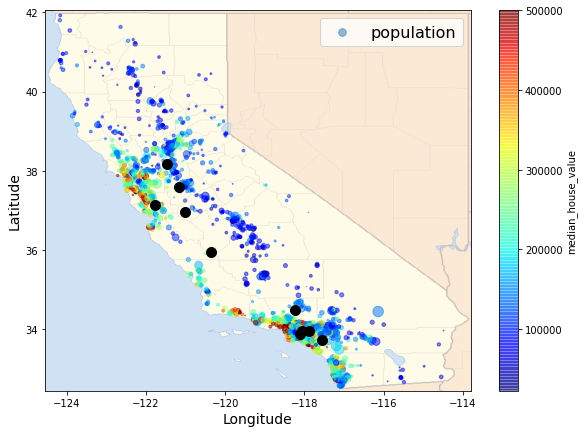

SSE is equal to: 9987.730660803387


In [ ]:
numberOfClusters = 10

HousingDataClustering03 = myKMeans()
data = housing_prepared.to_numpy()
HousingDataClustering03.driver(dataset=data, p=0, K=numberOfClusters)
print("Done")
print(HousingDataClustering03.centroidLocations)
myCentroids = HousingDataClustering03.centroidLocations
myCentroids = full_pipeline['scaler'].inverse_transform(HousingDataClustering03.centroidLocations)

california_img = mpimg.imread("/content/california.png")
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

for i in myCentroids: 
  plt.plot( i[0], i[1], color='black', marker='o', markersize=10)

#plt.plot( [centroids[0, 0], centroids[1, 0]], [centroids[0, 1], centroids[1, 1]], color='', marker='o')


plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()

print("SSE is equal to: " + str(HousingDataClustering03.SSE()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """


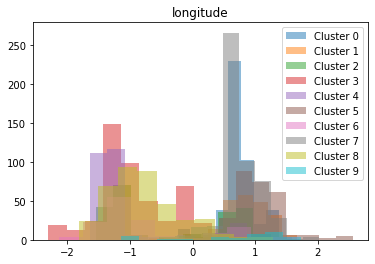

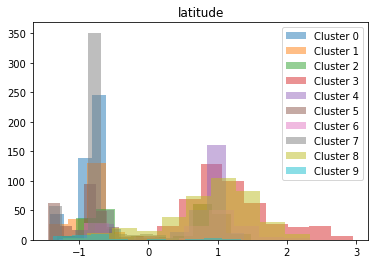

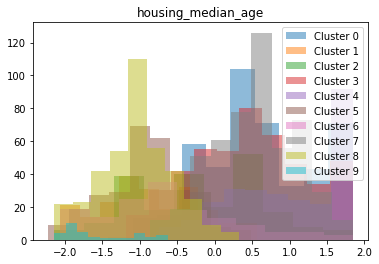

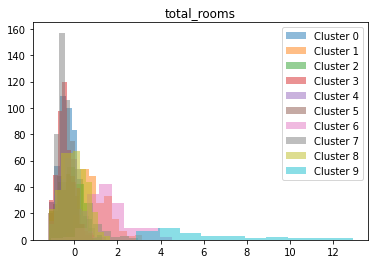

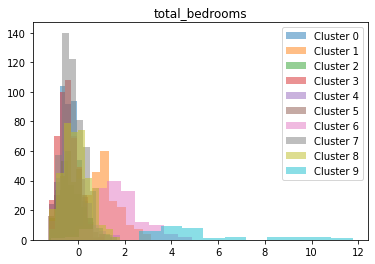

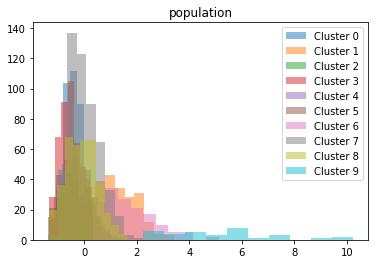

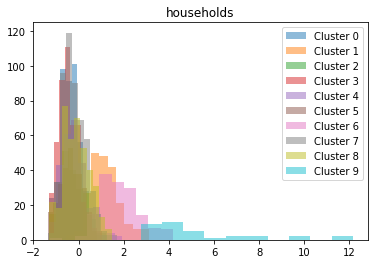

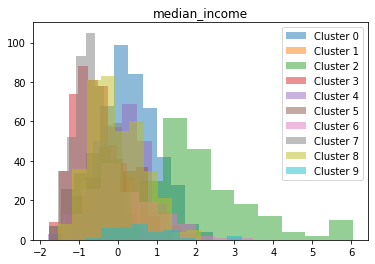

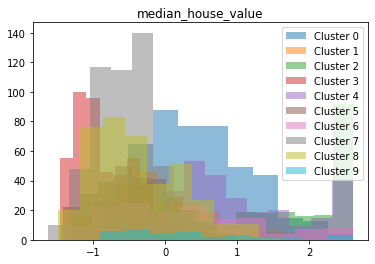

In [ ]:
columnLabels = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
clusterDataFrames = []

for i in range(numberOfClusters): 
  clusterDataFrames.append(pd.DataFrame(pd.np.empty((0, 9))))
  clusterDataFrames[i] = pd.DataFrame(HousingDataClustering03.centroidBuckets[i])
  # print(clusterDataFrames[i])
  clusterDataFrames[i].columns = columnLabels

for i in columnLabels: 
  for j in range(len(clusterDataFrames)): 
    plt.hist(clusterDataFrames[j][i], alpha=0.5, label='Cluster ' + str(j))
  plt.legend(loc='upper right')
  plt.title(i)
  plt.show()

In [ ]:
for idx, cluster in enumerate(HousingDataClustering03.centroidBuckets): 
  print("Statistics for cluster " + str(idx) + ": ")
  clusterDF = pd.DataFrame(cluster)
  clusterDF.columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
  print(clusterDF.describe())

Statistics for cluster 0: 
        longitude    latitude  housing_median_age  total_rooms  \
count  454.000000  454.000000          454.000000   454.000000   
mean     0.734809   -0.817927            0.585910    -0.274289   
std      0.265836    0.206989            0.739069     0.446906   
min     -0.441591   -1.420828           -1.421565    -1.196426   
25%      0.616263   -0.857266            0.091981    -0.573524   
50%      0.721547   -0.772732            0.490283    -0.338979   
75%      0.826831   -0.702287            1.187310     0.029659   
max      1.583873    0.617386            1.844508     1.473817   

       total_bedrooms  population  households  median_income  \
count      454.000000  454.000000  454.000000     454.000000   
mean        -0.357734   -0.383551   -0.335718       0.356316   
std          0.427649    0.434106    0.457890       0.697082   
min         -1.263161   -1.347862   -1.321736      -1.176933   
25%         -0.647161   -0.659518   -0.640220      -0.1159

Interestingly, as more and more importance is placed on outlier values (by increasing the p/k of the Minkovski distance we encourage more outlier-based clustering) we see greater importance placed on lat/long as well as total_rooms, total_bedrooms, and population. 

This is only furthered by the fact that when we look at which urban centers our cluster centers correspond to. From top to bottom, we have approximately, Sacramento, Stockton, San Jose, Salinas, Fresno, poor/rich LA, Pasadena, and Santa Ana. Pretty interesting. 

Lets plot a graph of each of the SSE vs iteration graph. Lets also trying to get a line for each p value (0, 1, infin). 

In [ ]:
SSEList = []

for p in range(3): 
  SSEList.append([])
  for cluster in range(1, 11): 
    HDC = myKMeans()
    data = housing_prepared.to_numpy()
    HDC.driver(dataset=data, p=p, K=cluster)
    SSEList[p].append(HDC.SSE())

print(SSEList)

[[26999.99999999996, 23600.798490827125, 21721.831070766497, 21361.534319964394, 16294.242996977204, 12622.375309762243, 13731.85100437939, 12974.25659897911, 11448.593240297198, 11330.755692143475], [26999.99999999996, 21298.417926767164, 18614.653060476125, 16188.661766553361, 17045.287625634086, 13302.293498852265, 13777.660967540038, 11279.341687415957, 11416.973546734049, 9888.519442755793], [26999.99999999996, 21050.11117842317, 20455.606924019587, 14584.828140191821, 14466.764419123921, 12262.931251630596, 12738.676933369035, 11936.510288139687, 11406.070599853274, 11330.100950666343]]


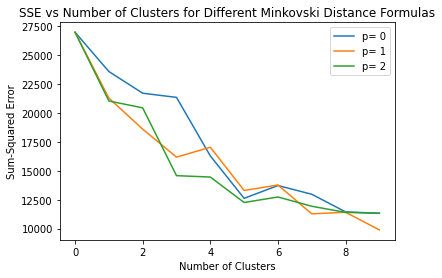

In [ ]:
import matplotlib.pyplot as plt
SSEList = np.array(SSEList).T.tolist()
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = SSEList
plt.xlabel("Number of Clusters")
plt.ylabel("Sum-Squared Error")
plt.title("SSE vs Number of Clusters for Different Minkovski Distance Formulas")
for i in range(len(y[0])):
    plt.plot([pt[i] for pt in y],label = 'p= %s'%i)
plt.legend()
plt.show()

What I find very interesting about each of these p values is that p = infinite has the most evenly distributed centroids. This makes a ton of sense. When p = infinite, we want to do our best to minimize the largest difference in dimension, so we want the contents of our clusters to be as similar as possible. 

In [ ]:
# lets create a table for each std deviation for each p for each cluster in p for each column
columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

stddev00 = []

for cluster in HousingDataClustering03.centroidBuckets: 
  clusterDF = pd.DataFrame(cluster)
  clusterDF.columns = columns
  tempList = []
  for column in columns: 
    tempList.append(clusterDF.describe()[column]['std'])
    
  stddev00.append(tempList)

stddev00 = np.array(stddev00).T.tolist()

stddev01 = []

for cluster in HousingDataClustering01.centroidBuckets: 
  clusterDF = pd.DataFrame(cluster)
  clusterDF.columns = columns
  tempList = []
  for column in columns: 
    tempList.append(clusterDF.describe()[column]['std'])
    
  stddev01.append(tempList)

stddev01 = np.array(stddev01).T.tolist()

stddev02 = []

for cluster in HousingDataClustering02.centroidBuckets: 
  clusterDF = pd.DataFrame(cluster)
  clusterDF.columns = columns
  tempList = []
  for column in columns: 
    tempList.append(clusterDF.describe()[column]['std'])
    
  stddev02.append(tempList)

stddev02 = np.array(stddev02).T.tolist()

print(stddev00)









[[0.2658360283975242, 0.35614147224915554, 0.9717645916445156, 0.5809816899356074, 0.6325784506096979, 0.40785352746783904, 0.8630213753835485, 0.30828986980744, 0.5785066042982597, 0.8496855516417575], [0.2069894059333369, 0.32620449887472125, 0.8652140765659108, 0.5841650808995125, 0.5899451010365634, 0.3453624863227399, 0.8400459697238886, 0.2875529595791883, 0.6502120128551286, 0.7967309258295643], [0.7390688219552135, 0.6449467340594957, 0.8656949515367205, 0.7600594503631257, 0.7770483426667012, 0.5372678001094646, 0.8711807506189129, 0.5584311987912052, 0.4697990786541161, 0.5058871621079124], [0.4469063908472618, 0.6633999638749635, 0.723576308995623, 0.38543304096625935, 0.454321288476732, 0.4347353118253262, 0.9774886012431172, 0.40889478433784443, 0.5504760778803255, 2.4984250331966593], [0.42764863150155363, 0.6624909996770041, 0.5412607785977814, 0.42455707259838865, 0.5459767378259774, 0.4705466012614567, 0.9460595397835915, 0.46801662273347466, 0.5633713928187388, 2.6093

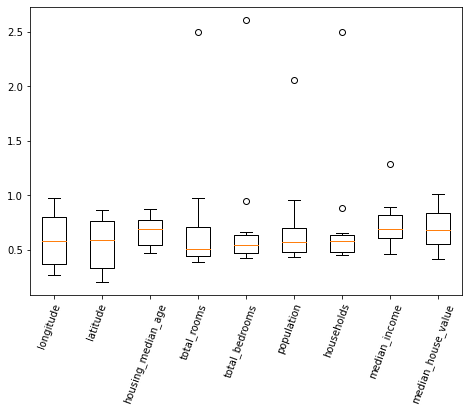

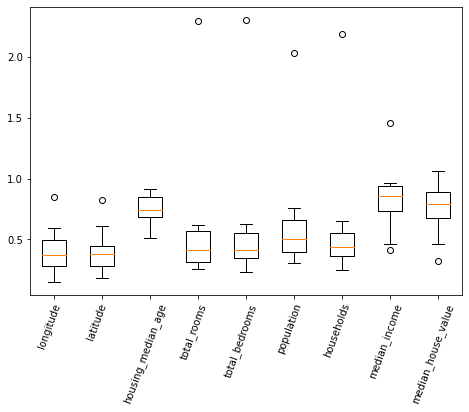

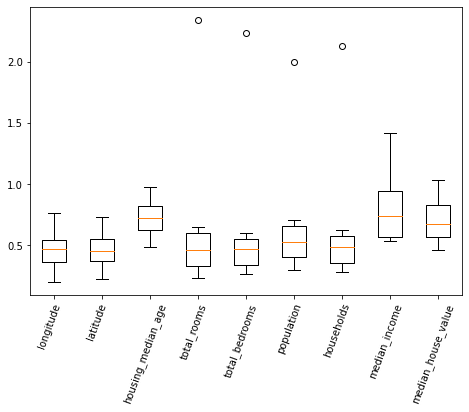

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(stddev00)

ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xticklabels(columns, rotation=70)

# create -5pt offset in x direction
from matplotlib.transforms import ScaledTranslation
dx, dy = -5, 0
offset = ScaledTranslation(dx / fig.dpi, dy / fig.dpi, fig.dpi_scale_trans)

# apply offset to all xticklabels
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

plt.show()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(stddev01)

ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xticklabels(columns, rotation=70)

# create -5pt offset in x direction
from matplotlib.transforms import ScaledTranslation
dx, dy = -5, 0
offset = ScaledTranslation(dx / fig.dpi, dy / fig.dpi, fig.dpi_scale_trans)

# apply offset to all xticklabels
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

plt.show()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(stddev02)

ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xticklabels(columns, rotation=70)

# create -5pt offset in x direction
from matplotlib.transforms import ScaledTranslation
dx, dy = -5, 0
offset = ScaledTranslation(dx / fig.dpi, dy / fig.dpi, fig.dpi_scale_trans)

# apply offset to all xticklabels
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

plt.show()

Note that the first graph is p=infinite, second is p=0, third is p=1. The y-axis is the SSE. 

We can see how the first method of Minkovski distance, p=infinite, reduces overall standard deviation while latter values of p (1 and 2) try to minimize standard deviation but allow for extreme values (median_income, housing_median_age). This is inline with the expected behavior of the p-values in minkovski distance where the infinite p value ensures that when clustering, no point is too distant from the cluster center. 

- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



Before I go into my analysis, I would like to talk about the weaknesses of K-means. K-means is very reliant on how the data is treated. This was visible with the dramatic changes in clustering following the scaling of the data. And this is due to how values are intrinsically weighted. By having median_housing_value be very high, a lot of weight is assigned to that one feature so clusters that cluster based off median_housing_value technically do reduce similarity but they pretty much disregard all other values. On the other hand, if we are to scale all features, we effectively assign equal priority to all features and this as well isn't helpful. As it doesn't particularly help us group values together in any meaningful way, by scaling we lose sense of some values being more important than others. 

In the future, I would go about modifying the data slightly. Asking the user to organize features by their importance and then scaling according to that importance and then employing K means. 

In terms of the California Housing Crisis, I think that clustering is great to break up the problem and then proceed accordingly. By using K-means and dividing up the problem, one can tailor solutions to each subsection/bucket and proceed accordingly. 

Looking at the SSE graph, it appears that 6-7 clusters is optimal for getting categories for Californian. Thsi is in-line with what is written in the blurb above. And as one can see in the SSE vs # of clusters graph above, there is only marginal benefit in SSE improvement after 6-7 clusters. 

So for buckets/clusters where houses are primarily defined by having massive median prices, it would be logical to add affordable housing. Another, albeit controversial, solution would be to improve job/living conditions in areas with low population such that people in higher, overcrowded areas would leave to these under-crowded areas. By looking at clusters and identifying which clusters are better off, which are worse off and moving people around accordingly, you would be able to alleviate the problem across the state.  

Once again, I believe that the primary benefit of clustering is not the ability to see highly similar housing locations, but extreme housing locations. This is supported by the case where we calculate the Minkovski distance with p = infinite where the clusters are centered over centers of extreme housing conditions. 

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 2:...".

Best of luck and have fun!